In [1]:
%load_ext cudf.pandas

# Windowed Computations

Xarray has built-in support for windowed operations:
1. [rolling](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations) - Sliding windows of fixed length.
2. [coarsen](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays) - block windows of fixed length.


In this notebook, we'll learn to 
1. Compute rolling, or sliding window, means along one or more dimensions.
2. Compute block averages along a dimension.
3. Use `construct` to reshape arrays so that a new dimension provides windowed views to the data.


In [2]:
%%cudf.pandas.profile

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

np.set_printoptions(threshold=10, edgeitems=2)
xr.set_options(display_expand_data=False)

%config InlineBackend.figure_format='retina'

                                                                                              
                                  Total time elapsed: 1.763 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [3]:
%%cudf.pandas.profile

ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

                                                                                                               
                                           Total time elapsed: 4.086 seconds                                   
                                        303 GPU function calls in 0.139 seconds                                
                                        18 CPU function calls in 0.012 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ isna                      │ 0          │ 0.000       │ 0.000       │ 10         │ 0.006       │ 0.001       │
│ to_timedelta              │ 0          │ 0.000       │ 0.000       │ 6          │ 0.005       │ 0.001       │
│ ndarray.reshape           │ 0          │ 0.000       │ 0.000       │ 2          │ 0.001       │ 0.001       │
│ Index                     │ 3          │ 0.008       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 178        │ 0.059       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__  │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 89         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__ │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.014       │ 0.007       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna
- to_timedelta
- ndarray.reshape

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=67341;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

## Rolling or moving windows

Rolling window operations 
1. can be applied along any dimension, or along multiple dimensions.
2. returns object of same shape as input
3. pads with NaNs to make (3) possible

Again, all common reduction operations are [available](https://docs.xarray.dev/en/stable/api.html#rolling-objects)

In [4]:
%%cudf.pandas.profile

rolling = ds.rolling(time=12, center=True)
rolling

DatasetRolling [time->12(center)]

                                                                                              
                                  Total time elapsed: 0.046 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{tip}
Xarrays' computation methods (`groupby`, `groupby_bins`, `rolling`, `coarsen`, `weighted`) all return special objects that represent the basic underlying computation pattern. For e.g. `rolling` above is a `DatasetRolling` object that represents 12-point rolling windows of the data in `ds` . It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).
```

In [5]:
%%cudf.pandas.profile

ds_rolling = rolling.mean()
ds_rolling

<xarray.Dataset>
Dimensions:    (time: 624, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 nan nan nan nan nan ... nan nan nan nan nan
    sst        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

                                                                                                                
                                           Total time elapsed: 1.560 seconds                                    
                                        769 GPU function calls in 0.324 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 304        │ 0.102       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 24         │ 0.010       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 12         │ 0.012       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.equals       │ 12         │ 0.019       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 360        │ 0.123       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 18         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__deepcopy__  │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.equals        │ 12         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__   │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__     │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__      │ 2          │ 0.013       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

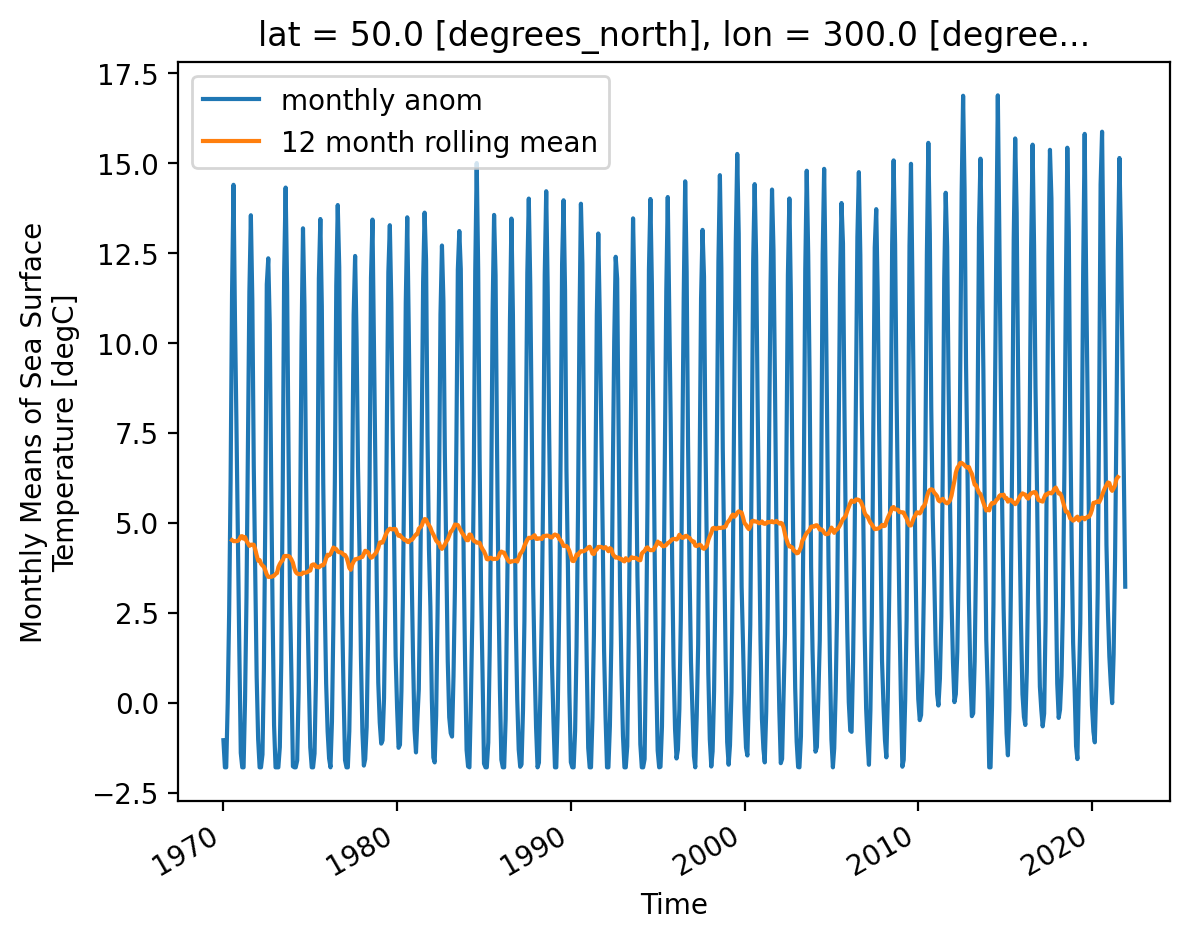

                                                                                                              
                                          Total time elapsed: 6.330 seconds                                   
                                        51 GPU function calls in 0.029 seconds                                
                                        3 CPU function calls in 0.021 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__     │ 8          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__    │ 36         │ 0.016       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.get_loc     │ 0          │ 0.000       │ 0.000       │ 2          │ 0.012       │ 0.006       │
│ Float32Index.__getitem__ │ 4          │ 0.004       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy       │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.get_loc     │ 1          │ 0.005       │ 0.005       │ 1          │ 0.009       │ 0.009       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Float32Index.get_loc
- Float64Index.get_loc

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=299106;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [6]:
%%cudf.pandas.profile

ds.sst.sel(lon=300, lat=50).plot(label="monthly anom")
ds_rolling.sst.sel(lon=300, lat=50).plot(label="12 month rolling mean")
plt.legend()

We can apply rolling mean along multiple dimensions as a 2D smoother in (lat, lon). Here is an example of a 5-point running mean applied along both the `lat` and `lon` dimensions

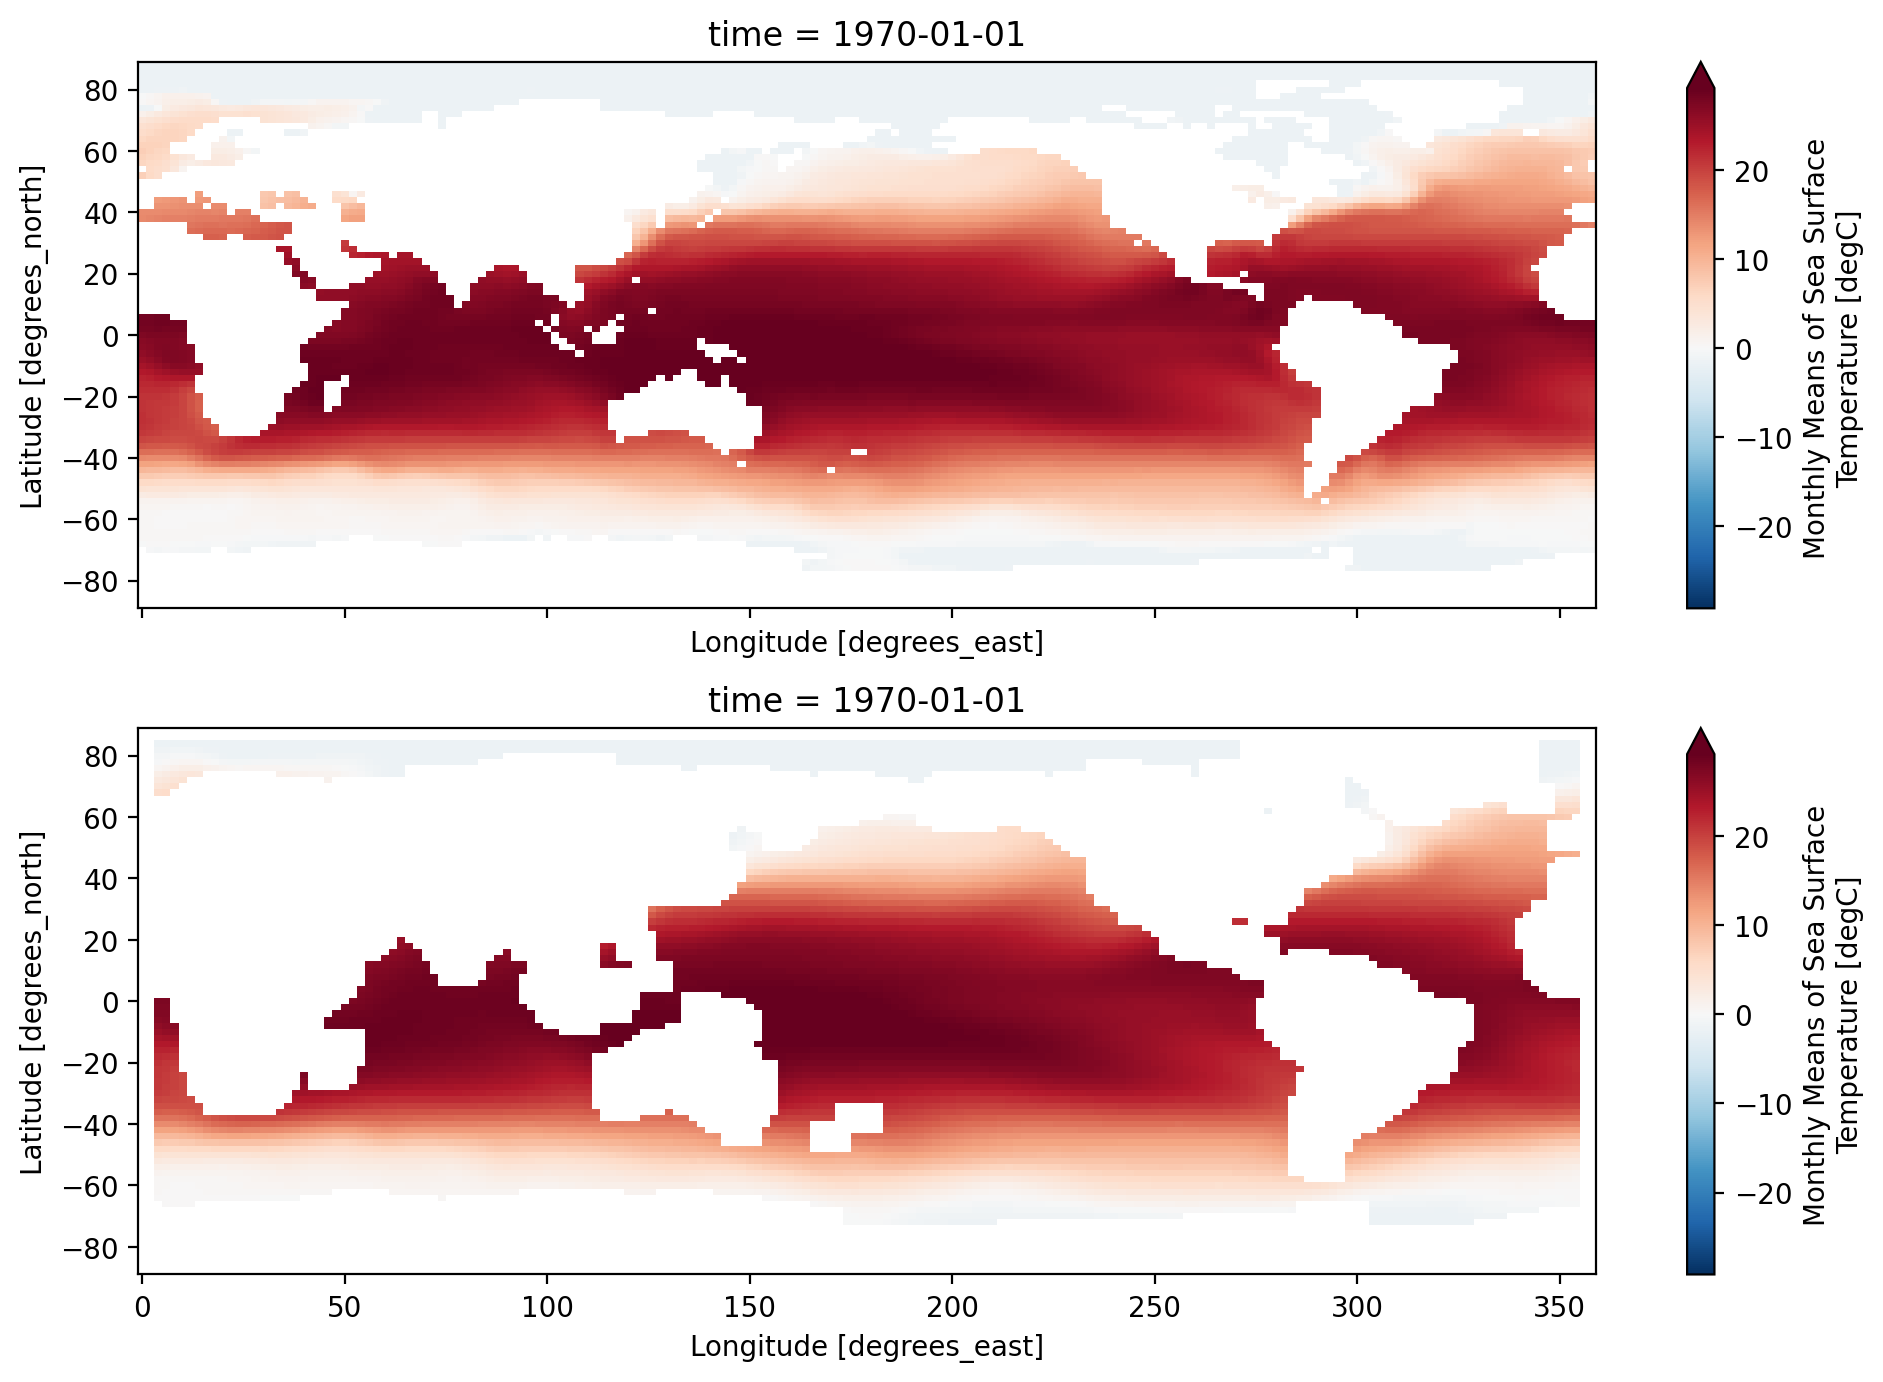

                                                                                                               
                                           Total time elapsed: 4.289 seconds                                   
                                        321 GPU function calls in 0.169 seconds                                
                                         2 CPU function calls in 0.001 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 23         │ 0.052       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__      │ 232        │ 0.075       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy         │ 26         │ 0.011       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 16         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__deepcopy__ │ 4          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.equals       │ 10         │ 0.014       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ isna                      │ 0          │ 0.000       │ 0.000       │ 2          │ 0.001       │ 0.001       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=736602;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [7]:
%%cudf.pandas.profile

extract = ds.sst.isel(time=0)
smoothed = extract.rolling(lon=5, lat=5, center=True).mean()

f, ax = plt.subplots(2, 1, sharex=True, sharey=True)
extract.plot(ax=ax[0], robust=True)
smoothed.plot(ax=ax[1], robust=True)
f.set_size_inches((10, 7))
plt.tight_layout()

Note the addition of NaNs at the data boundaries and near continental boundaries.

### Custom reductions

While common reductions are implemented by default, sometimes it is useful to apply our own windowed operations. For these uses, Xarray provides the `construct` methods for [DataArray.rolling](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.construct.html) and [Dataset.rolling](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DatasetRolling.construct.html).

For rolling over a dimension `time` with a window size `N`, `construct` adds a new dimension (with user-provided name) of size `N`. 

We illustrate with a simple example array:

In [8]:
%%cudf.pandas.profile

simple = xr.DataArray(np.arange(10), dims="time", coords={"time": np.arange(10)})
simple

<xarray.DataArray (time: 10)>
0 1 2 3 4 5 6 7 8 9
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9

                                                                                                             
                                          Total time elapsed: 0.164 seconds                                  
                                       107 GPU function calls in 0.045 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 95         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__  │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

We call `construct` and provide a name for the new dimension: `window`

In [9]:
%%cudf.pandas.profile

# adds a new dimension "window"
simple.rolling(time=5, center=True).construct("window")

<xarray.DataArray (time: 10, window: 5)>
nan nan 0.0 1.0 2.0 nan 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 nan 7.0 8.0 9.0 nan nan
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

                                                                                                             
                                          Total time elapsed: 0.153 seconds                                  
                                       91 GPU function calls in 0.038 seconds                                
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__      │ 81         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 7          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{exercise} 
:label: rolling-center
Illustrate the difference between `center=True` and `center=False` for rolling by looking at the `construct`-ed array.
```
````{solution} rolling-center
:class: dropdown
```python
display("center=True")
display(simple.rolling(time=5, center=True).construct("window"))

display("center=False")
display(simple.rolling(time=5, center=False).construct("window"))
```
````

## Coarsening

`coarsen` does something similar to `rolling`, but allows us to work with discrete *non-overlapping* blocks of data.

You will need to specify `boundary` if the length of the dimension is not a multiple of the window size ("block size"). You can choose to
1. `trim` the excess values
2. `pad` with NaNs

Again, all standard reductions are [implemented](https://docs.xarray.dev/en/stable/api.html#coarsen-objects).

In [10]:
%%cudf.pandas.profile

coarse = ds.coarsen(lon=5, lat=5)
coarse

DatasetCoarsen [windows->{'lon': 5, 'lat': 5},side->left]

                                                                                              
                                  Total time elapsed: 0.039 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Xarrays' computation methods (groupby, groupby_bins, rolling, coarsen, weighted) all return special objects that represent the basic underlying computation pattern. For e.g. `coarse` above is a `DatasetCoarsen` object that represents 5-point windows along lat, lon of the data in `ds`. It is usually helpful to save and reuse these objects for multiple operations (e.g. a mean and standard deviation calculation).

In [11]:
%%cudf.pandas.profile

# we expect an error here because lat has size 89, which is not divisible by block size 5
coarse.mean()

ValueError: Could not coarsen a dimension of size 89 with window 5 and boundary='exact'. Try a different 'boundary' option.

                                                                                              
                                  Total time elapsed: 6.357 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [12]:
%%cudf.pandas.profile

coarse = ds.coarsen(lat=5, lon=5, boundary="trim").mean()
coarse

<xarray.Dataset>
Dimensions:    (time: 624, nbnds: 2, lat: 17, lon: 36)
Coordinates:
  * lat        (lat) float32 84.0 74.0 64.0 54.0 ... -46.0 -56.0 -66.0 -76.0
  * lon        (lon) float32 4.0 14.0 24.0 34.0 44.0 ... 324.0 334.0 344.0 354.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.757 -1.78 -1.8 ... -1.716 -1.685 nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

                                                                                                               
                                           Total time elapsed: 0.560 seconds                                   
                                        324 GPU function calls in 0.145 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 198        │ 0.068       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 14         │ 0.012       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 3          │ 0.007       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 91         │ 0.030       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__  │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__ │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.011       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

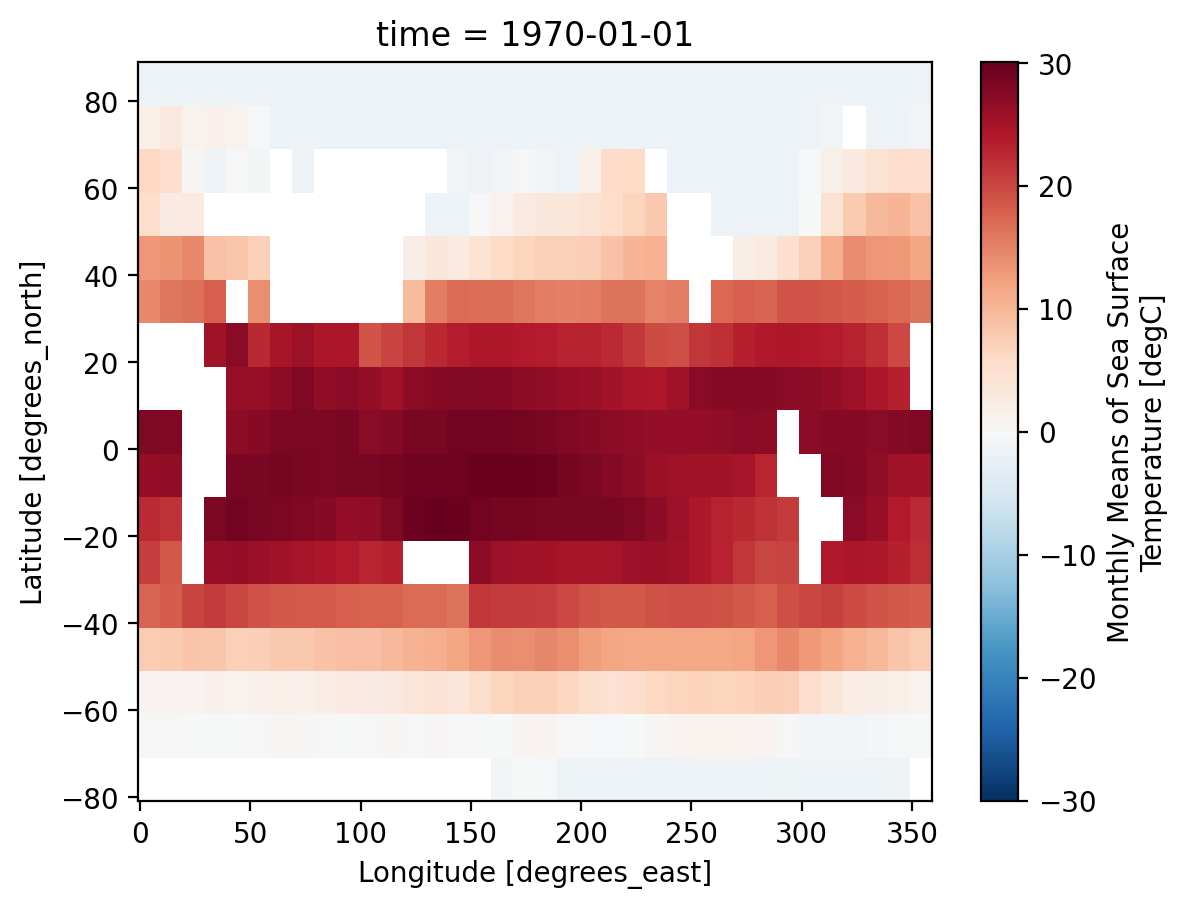

                                                                                                               
                                           Total time elapsed: 1.843 seconds                                   
                                        32 GPU function calls in 0.015 seconds                                 
                                         1 CPU function calls in 0.001 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 2          │ 0.005       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__      │ 26         │ 0.008       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ isna                      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=795917;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [13]:
%%cudf.pandas.profile

coarse.sst.isel(time=0).plot();

### Custom reductions

Like `rolling`, `coarsen` also provides a `construct` method for custom block operations. 

```{tip} 
`coarsen.construct` is a handy way to reshape Xarray objects.
```

Consider a "monthly" 1D timeseries. This simple example has one value per month for 2 years

In [14]:
%%cudf.pandas.profile

months = xr.DataArray(
    np.tile(np.arange(1, 13), reps=2),
    dims="time",
    coords={"time": np.arange(1, 25)},
)
months

<xarray.DataArray (time: 24)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24

                                                                                                             
                                          Total time elapsed: 0.161 seconds                                  
                                       107 GPU function calls in 0.044 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 95         │ 0.030       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Now we reshape to get one new dimension `year` of size 12.

In [15]:
%%cudf.pandas.profile

# break "time" into two new dimensions: "year", "month"
months.coarsen(time=12).construct(time=("year", "month"))

<xarray.DataArray (year: 2, month: 12)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
    time     (year, month) int64 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24
Dimensions without coordinates: year, month

                                                                                                        
                                       Total time elapsed: 0.067 seconds                                
                                     5 GPU function calls in 0.001 seconds                              
                                     0 CPU function calls in 0.000 seconds                              
                                                                                                        
                                                     Stats                                              
                                                                                                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function           ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__ │ 5          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

````{exercise} 
:label: rolling-pad

Imagine the array `months` was one element shorter. Use `boundary="pad"` and the `side` kwarg to reshape `months.isel(time=slice(1, None))` to a 2D DataArray with the following values:

```python
array([[nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]])
```
````
````{solution} rolling-pad
:class: dropdown

```python
months.isel(time=slice(1, None)).coarsen({"time": 12}, boundary="pad", side="right").construct(
    time=("year", "month")
)
```
````

Note that `coarsen` pads with NaNs. For more control over padding, use
[DataArray.pad](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.pad.html) explicitly.

## Going further

1. See the documentation on [rolling](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations) and [coarsen](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays).
2. Follow the tutorial on [high-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html#)